### Example of Reinforcement Learning 

linear Approxiatio for Policy evaluation.

state_size:  4
action_size:  2


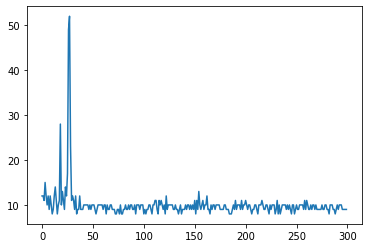

In [10]:
import torch.nn as nn
import torch
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.distributions import Categorical
import matplotlib.pyplot as plt
import gym 


def plot_learning_curve(x, scores, figure_file='test'):
    running_avg = np.zeros(len(scores))
    for i in range(len(running_avg)):
        running_avg[i] = np.mean(scores[max(0, i-100):(i+1)])
    plt.plot(x, running_avg)
    plt.title('Running average of previous 100 scores')
    #plt.savefig(figure_file)
    
    
class Actor(nn.Module):
    ## Given the state, what are the probabilities of each action?
    def __init__(self, state_size, action_size,fc_dim1=256, fc_dim2=256, alpha=0.00001):
        super(Actor, self).__init__()
        self.state_size = state_size
        self.action_size = action_size
        self.linear1 = nn.Linear(state_size, fc_dim1)
        self.linear2 = nn.Linear(fc_dim1, fc_dim2)
        self.linear3 = nn.Linear(fc_dim2, action_size)
        
        self.optimizer = optim.Adam(self.parameters(), lr=alpha, weight_decay=1e-5)
        self.loss_fun = nn.MSELoss()
        
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    def forward(self, state):
        #print ('State Actor: ', state.shape, state)
        output =torch.tensor(state.astype(float)).view(-1,self.state_size).to(self.device)
        output = F.relu(self.linear1(output))
        output = F.relu(self.linear2(output))
        output = self.linear3(output)
        output = F.softmax(output, dim=1)
        distribution = Categorical(output)
        #display('distribution: ', distribution)
        return distribution #pi(a/s)
        
class Critic(nn.Module):
    ## Given the state, what is the action value for each ?
    def __init__(self, state_size, action_size, alpha=1e-04,fc_dim1=256, fc_dim2=256,):
        super(Critic, self).__init__()
        self.state_size = state_size
        self.action_size = action_size
        ## Assume output one rewards as the output
        self.linear1 = nn.Linear(state_size, fc_dim1)
        self.linear2 = nn.Linear(fc_dim1, fc_dim2)
        self.linear3 = nn.Linear(fc_dim2, action_size)
        
        self.optimizer = optim.Adam(self.parameters(), lr=alpha, weight_decay=1e-5)
        self.loss_fun = nn.MSELoss()
        
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    def forward(self, state):
        #Sate is numpy array
        #print ('State Critic: ', state.dim, state)
        x = torch.tensor(state.astype(float)).to(self.device)
        output = F.relu(self.linear1(x))
        output = F.relu(self.linear2(output))
        #display('State: ', state)
        #print (x)
        Qs = self.linear3(output)
        return Qs ##Output the each Q value for each action
    
class Agent():
    def __init__(self, gamma, actor, critic, env, episods=1,):
        
        self.env = env
        self.episods = episods
        self.gamma = gamma
        
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        self.actor = actor.double().to(self.device)
        self.critic = critic.double().to(self.device)
        

    def train(self):
        rewards_list =[]
        
        for i in range(self.episods):
            total_rewards = 0
            
            self.actor.train()
            self.critic.train()

            #Initial State
            state = self.env.reset()
            
            ## Sample a action
            distribution = self.actor(state)
            action = distribution.sample().to(self.device)
  
            done=False
            while not done:
                self.actor.zero_grad()
                self.critic.zero_grad()
                
                ## Sample a action
                #distribution = self.actor(state)
                #action = distribution.sample().to(self.device)
                
                #print ('Action: ', action)
                state_next, reward, done, _ = self.env.step(action.item())
                total_rewards+=reward
                
                reward = torch.tensor(reward, requires_grad=True,dtype=torch.float64).to(self.device) #Convert to tensor               
                
                ##Sample the next action
                distribution = self.actor(state_next)
                action_next = distribution.sample().to(self.device) #tensor
                #print('action_next: ', action_next)

                ##obtain the TD target value and ready for critic update
                #print (action_next.item())
                target = (reward + self.gamma * self.critic(state_next)[action_next.item()]*(1.0 - int(done))).to(self.device)

                pred = self.critic(state)[action.item()].to(self.device)
                #display(target, ' ' , pred)
                
                ## Have the loss function for actor and update actor params
                loss_actor = (-distribution.log_prob(action) * (target-pred)).to(self.device)  #(target-pred.mean())
                            
                loss_critic = ((target - pred)**2).to(self.device)
                
                (loss_actor + loss_critic).backward()
                #loss_actor.backward(retain_graph=True)
                #loss_critic.backward()
                
                ##Update the state                          
                state = state_next
                action = action_next
                                
                self.critic.optimizer.step() 
                self.actor.optimizer.step() 
            
            rewards_list.append(total_rewards)
            
        
        x = [i+1 for i in range(self.episods)]
        plot_learning_curve(x, rewards_list)
        

if __name__ == '__main__':
    ## Define the Env
    #env = gym.make("CartPole-v1")  
    env = gym.make("AirRaid-ram-v0") 
    
    #env = gym.make("Pendulum-v0")
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n
    print ('state_size: ', state_size)
    print ('action_size: ', action_size)

    actor = Actor(state_size, action_size)
    critic = Critic(state_size, action_size)
    
    agent = Agent(0.99, actor, critic, env,episods=2000)
    agent.train()
    


In [71]:
np.amax([np.array([1,2,3,4])])

4

In [73]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print (device)

cpu


In [364]:
ini_array1 = np.array([[1, 2, 3], [2, 4, 5], [1, 2, 3]]) 
print (ini_array1)
print (ini_array1.flatten())

[[1 2 3]
 [2 4 5]
 [1 2 3]]
[1 2 3 2 4 5 1 2 3]


In [347]:
for i in (5,):
    print (i)

5


In [1]:
2**24

16777216